# Финальный проект

## Подготовка к выполнению проекта

Оператор связи хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.  

Описание полей данных:  
`'BeginDate'` – дата начала пользования услугами;  
`'EndDate'` – дата окончания пользования услугами;  
`'Type'` – тип договора: ежемесячный, годовой и т.д;  
`'PaperlessBilling'` – факт выставления счёта на электронную почту;  
`'PaymentMethod'` – способ оплаты;  
`'MonthlyCharges'` – ежемесячные траты на услуги;  
`'TotalCharges'` – всего потрачено денег на услуги;  
`'Dependents'` – наличие иждивенцев;  
`'SeniorCitizen'` – наличие пенсионного статуса по возрасту;  
`'Partner'` – наличие супруга(и);  
`'MultipleLines'` – наличие возможности ведения параллельных линий во время звонка.  

### Цель проекта

Целью проекта является разработка и обучение модели, которая сможет предсказать уход клиента. Целевой метрикой является AUC-ROC, её значение должно быть не менее 0.85. Дополнительно будут расмотрены значения метрики Accuracy.

### Импорт библиотек и функций

Для начала, загрузим необходимые библиотеки и зафиксируем случайное состояние в константе `RS`.

In [1]:
! pip install -U imbalanced-learn
! pip install lightgbm
! pip install phik

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from phik.report import correlation_report, plot_correlation_matrix
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
# функция для заполнения пропущенных значений в столбце 'total_charges'
def fill_charges(dataframe):
    df = dataframe.copy()
    if df['type'] == 'One year':
        df['total_charges'] = df['monthly_charges'] * 12
    elif df['type'] == 'Two year':
        df['total_charges'] = df['monthly_charges'] * 24
    return df    

In [3]:
# функция для перевода столбцов в категориальный тип
def to_cat_type(dataframe):
    df = dataframe.copy()
    for c in df.columns:
        col_type = df[c].dtype
        if col_type == 'object':
            df[c] = df[c].astype('category')
    return df

In [4]:
# функция для кодирования через OHE
def ohe(df):
    data_ohe = encoder.transform(df[cat])
    data_ohe = pd.DataFrame(data_ohe, columns=encoder.get_feature_names_out())
    df.reset_index(drop=True, inplace=True) 
    data_coded = pd.DataFrame()
    data_coded[encoder.get_feature_names_out()] = data_ohe
    data_coded[num] = df[num]
    return data_coded

In [5]:
RS = 100423

### Загрузка данных

Загрузим каждый датасет в отдельную переменную. В качестве путей к csv-файлам укажем ссылки, по которым расположены данные.

In [6]:
data_contract = pd.read_csv('https://code.s3.yandex.net/datasets/contract_new.csv')
data_internet = pd.read_csv('https://code.s3.yandex.net/datasets/internet_new.csv')
data_personal = pd.read_csv('https://code.s3.yandex.net/datasets/personal_new.csv')
data_phone = pd.read_csv('https://code.s3.yandex.net/datasets/phone_new.csv')

Для того, чтобы иметь представление о данных, выведем по несколько строчек из каждой таблицы.

In [7]:
print("Таблица contract_new:")
display(data_contract.sample(3, random_state=RS))
print("\nТаблица internet_new:")
display(data_internet.sample(3, random_state=RS))
print("\nТаблица personal_new:")
display(data_personal.sample(3, random_state=RS))
print("\nТаблица phone_new")
display(data_phone.sample(3, random_state=RS))

Таблица contract_new:


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
4412,8042-RNLKO,2014-08-01,No,One year,No,Bank transfer (automatic),25.45,1679.7
4089,4282-YMKNA,2019-03-01,No,Month-to-month,Yes,Electronic check,74.75,822.25
6800,1113-IUJYX,2018-08-01,No,One year,No,Mailed check,105.95,1964.31



Таблица internet_new:


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1749,2528-HFYZX,Fiber optic,No,Yes,No,No,No,No
2152,1724-BQUHA,Fiber optic,No,No,No,No,Yes,Yes
1949,2636-OHFMN,DSL,No,Yes,No,No,Yes,Yes



Таблица personal_new:


,customerID,gender,SeniorCitizen,Partner,Dependents
4412,8042-RNLKO,Male,0,No,No
4089,4282-YMKNA,Female,0,No,No
6800,1113-IUJYX,Female,0,Yes,No



Таблица phone_new


,customerID,MultipleLines
812,2267-FPIMA,Yes
3247,2227-JRSJX,No
1468,1971-DTCZB,Yes


Во всех таблицах имеется столбец `'customer_ID'`. Именно по нему, в дальнейшем и будем производить объединение таблиц.

### Первичный анализ данных

Выведем информацию о данных методом `info()`.

In [8]:
print("Таблица contract_new:")
data_contract.info()
print("\nТаблица internet_new:\n")
data_internet.info()
print("\nТаблица personal_new:\n")
data_personal.info()
print("\nТаблица phone_new\n")
data_phone.info()

Таблица contract_new:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB

Таблица internet_new:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-nu

In [9]:
print("Таблица contract_new:")
display(data_contract.describe(include='all'))
print("\nТаблица internet_new:\n")
display(data_internet.describe(include='all'))
print("\nТаблица personal_new:\n")
display(data_personal.describe(include='all'))
print("\nТаблица phone_new\n")
display(data_phone.describe(include='all'))

Таблица contract_new:


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
count,7043,7043,7043,7043,7043,7043,7043.000000,7043
unique,7043,77,67,3,2,4,NaN,6658
top,7590-VHVEG,2014-02-01,No,Month-to-month,Yes,Electronic check,NaN,
freq,1,366,5942,3875,4171,2365,NaN,11
mean,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN



Таблица internet_new:



,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785



Таблица personal_new:



,customerID,gender,SeniorCitizen,Partner,Dependents
count,7043,7043,7043.000000,7043,7043
unique,7043,2,NaN,2,2
top,7590-VHVEG,Male,NaN,No,No
freq,1,3555,NaN,3641,4933
mean,NaN,NaN,0.162147,NaN,NaN
std,NaN,NaN,0.368612,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN
50%,NaN,NaN,0.000000,NaN,NaN
75%,NaN,NaN,0.000000,NaN,NaN



Таблица phone_new



,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


Из данной информации можно сделать следующие выводы:
* большинство признаков являются категориальными, их будет необходимо закодировать;
* некоторые признаки имеют неверный тип данных, например, категориальный признак `'SeniorCitizen'` имеет тип `int64`, а непрерывный	`'TotalCharges'` - тип `object`;
* все признаки имеют значение, нет неинформативных признаков: признак `'customerID'` понадобится для соединения таблиц, а из признаков `'BeginDate'` и `'EndDate'` можно будет создать дополнительный признак - время, которое человек являлся (или до сих пор является) клиентом.

### Анализ числовых признаков

В первичном анализе можем взглянуть на распределение признаков. Выведем графики для признаков `'MonthlyCharges'` и `'TotalCharges'`. 

#### `'MonthlyCharges'`

Для начала взглянем на гистограмму для признака `'MonthlyCharges'`.

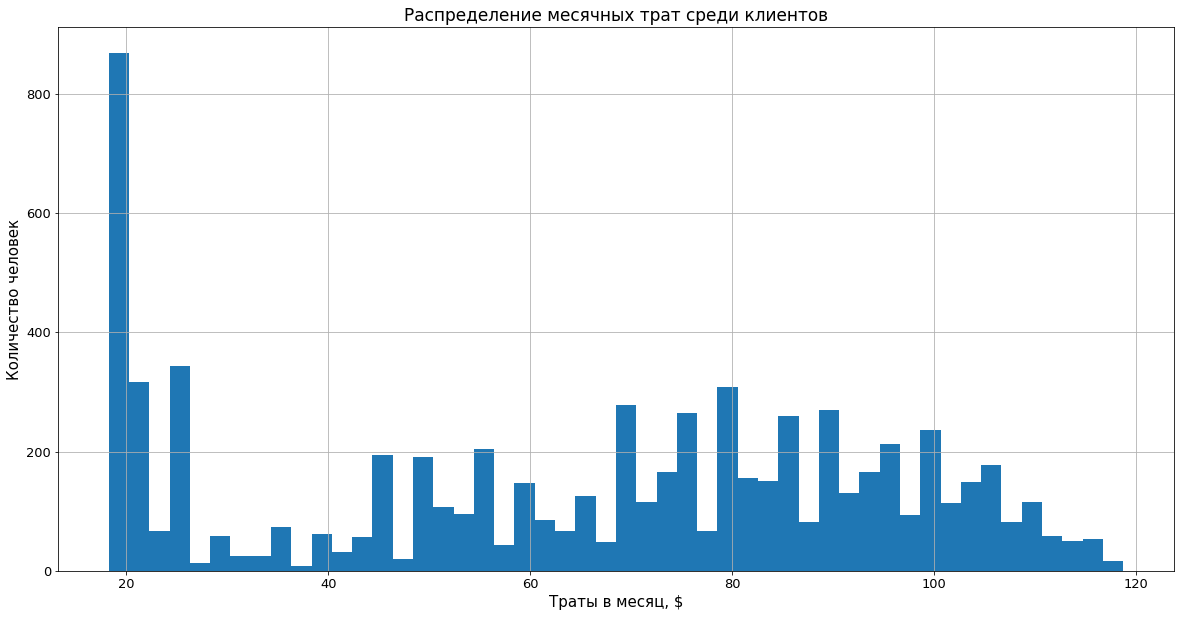

In [11]:
data_contract['MonthlyCharges'].hist(figsize=(20, 10), bins=50).tick_params(labelsize=13)
plt.title('Распределение месячных трат среди клиентов', fontsize=17)
plt.ylabel('Количество человек', fontsize=15)
plt.xlabel('Траты в месяц, $', fontsize=15);

На гистограмме можно увидеть очень большое количество значений около нуля. Эти значения нужно будет проанализировать поглубже во время предобработки.

Взглянем на диаграмму размаха.

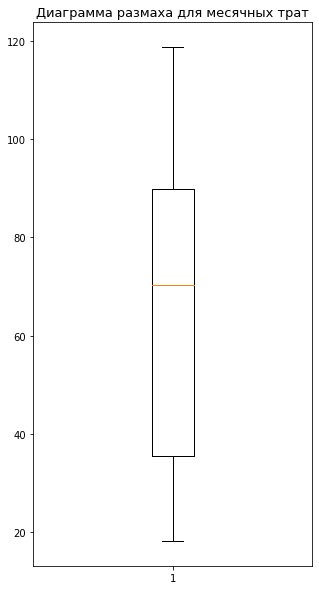

In [17]:
plt.figure(figsize=(5, 10))
plt.boxplot(data_contract['MonthlyCharges'])
plt.title('Диаграмма размаха для месячных трат', fontsize=13);

На диаграмме размаха выбросов нет. С этим можно согласиться, так как траты распределены достаточно равномерно не считая околонулевых значений. 

#### `'TotalCharges'`

Построим гистограмму и диаграмму размаха для столбца `'TotalCharges'`.

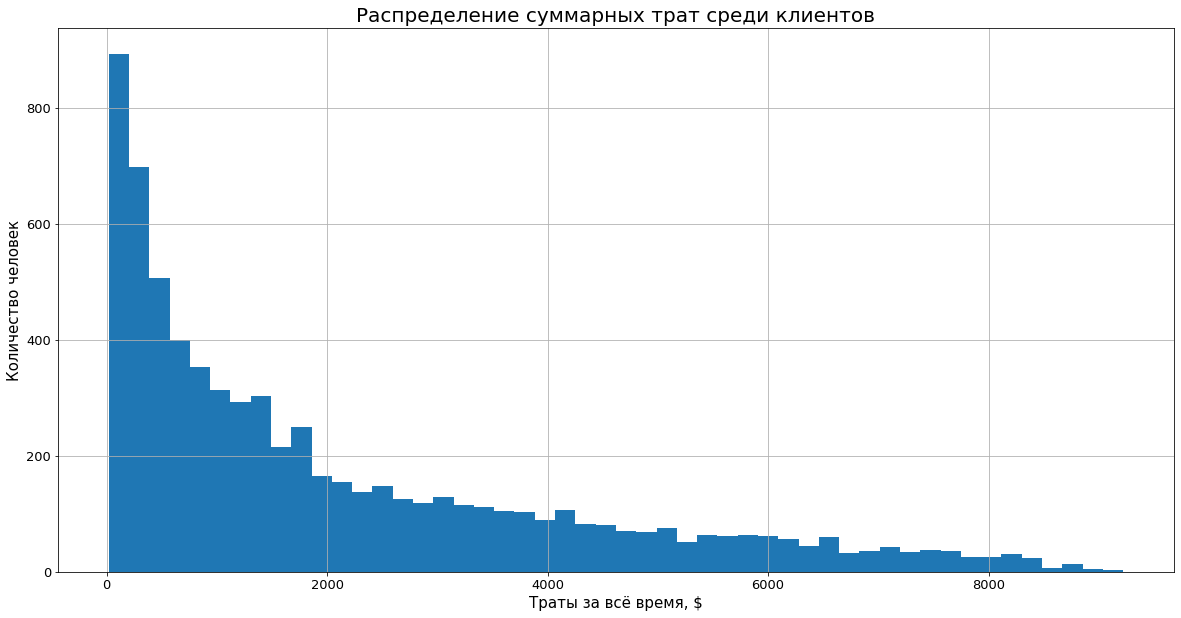

In [18]:
#для графика избавимся от некорректных строковых значений в столбце, в дальнейшем разберём их подробнее
pd.to_numeric(data_contract['TotalCharges'], errors='coerce').dropna().hist(figsize=(20, 10), bins=50).tick_params(labelsize=13) 
plt.title('Распределение суммарных трат среди клиентов', fontsize=20)
plt.ylabel('Количество человек', fontsize=15)
plt.xlabel('Траты за всё время, $',fontsize=15);

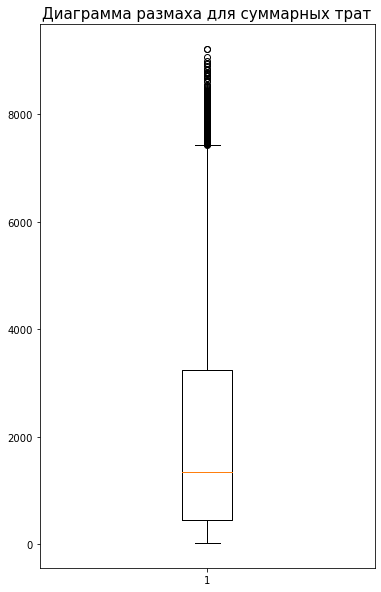

In [20]:
plt.figure(figsize=(6, 10))
plt.boxplot(pd.to_numeric(data_contract['TotalCharges'], errors='coerce').dropna())
plt.title('Диаграмма размаха для суммарных трат', fontsize=15);

Также, выведем методом `describe()` информацию о столбце, так как до изменения типа данных информация была некорректной:

In [21]:
pd.to_numeric(data_contract['TotalCharges'], errors='coerce').describe()

count    7032.000000
mean     2118.621822
std      2112.736199
min        19.050000
25%       439.745000
50%      1345.275000
75%      3239.317500
max      9221.380000
Name: TotalCharges, dtype: float64

Пик распределения находится недалеко от нуля, после этого график плавно убывает. Медианное значение равно 1345, диаграмма размаха также показала наличие выбросов, от них нужно будет избавиться.

### Целевой признак

Целевым признаком является столбец `'EndDate'`, однако перед передачей данных в модель, его будет необходимо преобразовать. В данном столбце содержится дата ухода клиента из компании, или значение `'No'`, если клиент не уходил. Взглянем на баланс классов в данных. Для этого преобразуем значение `'No'` в `0`, а дату ухода в `1`.

In [22]:
data_contract['EndDate'].replace({'No': 0}, inplace=True) #заменяем значение 'No' на 0
data_contract.loc[data_contract['EndDate'] != 0, ['EndDate']] = 1 #остальные значения меняем на 1
data_contract.sample(10, random_state=RS)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
4412,8042-RNLKO,2014-08-01,0,One year,No,Bank transfer (automatic),25.45,1679.7
4089,4282-YMKNA,2019-03-01,0,Month-to-month,Yes,Electronic check,74.75,822.25
6800,1113-IUJYX,2018-08-01,0,One year,No,Mailed check,105.95,1964.31
662,3030-ZKIWL,2020-01-01,0,Month-to-month,No,Mailed check,20.05,20.65
6956,2451-YMUXS,2014-07-01,1,Two year,Yes,Bank transfer (automatic),64.55,3292.05
2114,7707-PYBBH,2016-10-01,1,Month-to-month,Yes,Mailed check,61.90,1258.43
4538,0378-TOVMS,2019-10-01,0,Month-to-month,No,Electronic check,85.80,363.79
2282,1587-FKLZB,2014-07-01,1,Month-to-month,Yes,Credit card (automatic),99.50,2943.21
4387,5868-YTYKS,2020-01-01,0,Month-to-month,Yes,Mailed check,20.25,22.07
2133,8051-HJRLT,2019-09-01,0,Month-to-month,Yes,Electronic check,70.55,356.28


In [23]:
data_contract['EndDate'].value_counts()
print(
    f'Значение 0 составляет {(data_contract["EndDate"].value_counts()[0] / data_contract.shape[0] * 100).round(1)}% от всех данных')
print(
    f'Значение 1 составляет {(data_contract["EndDate"].value_counts()[1] / data_contract.shape[0] * 100).round(1)}% от всех данных')

Значение 0 составляет 84.4% от всех данных
Значение 1 составляет 15.6% от всех данных


В данных присутствует существенный дисбаланс классов. Этот вопрос тоже потребуется решить. 

### Промежуточный вывод

Для выполнения задачи придётся провести существенную предобработку данных, так как необходимо преобразовать значительное количество признаков, к тому же, все признаки находятся в разных таблицах, их необходимо корректно соединить. Также, нужно будет создать дополнительный признак из столбцов с датами, и обратить внимание на дисбаланс класов. Дополнительно нужно будет проверить мультиколлинеарность и выявить особенности в данных.

### План проекта

1. Загрузить все датасеты в переменные. Вывести основную информацию о данных методами `info()` и `describe()`.
2. Ознакомиться с данными. Провести первичный анализ данных.
3. Предобработка данных.
4. Кодировка признаков. Добавление дополнительных признаков.
5. Подбор гиперпараметров и обучение нескольких моделей на кроссвалидации. Выбор лучшей модели.
6. Проверка лучшей модели на тесте. Анализ важности признаков лучшей модели.

## Код решения задачи

### Предобработка данных

#### Создание синтетического признака

Инициализируем датафрейм `dates` для того, чтобы создать новый признак `'days'`. Признак будет показывать, сколько дней человек являлся или является клиентом.

In [24]:
# создание дополнительного признака, показывающего сколько дней человек является\являлся клиентом
dates = pd.read_csv(
    'https://code.s3.yandex.net/datasets/contract_new.csv')[['customerID', 'BeginDate', 'EndDate']]
dates.replace({'No': '2020-02-01'}, inplace=True)
dates['BeginDate'] = pd.to_datetime(dates['BeginDate'], format='%Y-%m-%d')
dates['EndDate'] = pd.to_datetime(dates['EndDate'], format='%Y-%m-%d')
dates.sample(3, random_state=RS)

,customerID,BeginDate,EndDate
4412,8042-RNLKO,2014-08-01,2020-02-01
4089,4282-YMKNA,2019-03-01,2020-02-01
6800,1113-IUJYX,2018-08-01,2020-02-01


In [25]:
dates['days'] = ((dates['EndDate'] - dates['BeginDate'])/np.timedelta64(1, 'D')).astype('int64')
dates.sample(3, random_state=RS)

,customerID,BeginDate,EndDate,days
4412,8042-RNLKO,2014-08-01,2020-02-01,2010
4089,4282-YMKNA,2019-03-01,2020-02-01,337
6800,1113-IUJYX,2018-08-01,2020-02-01,549


#### Объединение данных

Соеденим все таблицы в итоговый фрейм под названием `data`. Объединять будем по столбцу `'customerID'`.

In [26]:
data = (data_contract.merge(data_personal, how='left', on='customerID')
        .merge(data_internet, how='left', on='customerID')
        .merge(data_phone, how='left', on='customerID')
        .merge(dates[['customerID', 'days']], how='left', on='customerID'))
data.sample(3, random_state=RS)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,days
4412,8042-RNLKO,2014-08-01,0,One year,No,Bank transfer (automatic),25.45,1679.7,Male,0,...,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,2010
4089,4282-YMKNA,2019-03-01,0,Month-to-month,Yes,Electronic check,74.75,822.25,Female,0,...,No,Fiber optic,No,No,No,No,No,No,Yes,337
6800,1113-IUJYX,2018-08-01,0,One year,No,Mailed check,105.95,1964.31,Female,0,...,No,Fiber optic,Yes,Yes,No,Yes,Yes,Yes,No,549


#### Обработка названий столбцов и пропусков

Приведём названия всех столбцов к lower_snake_case.

In [27]:
data.rename({'customerID': 'customer_id',
             'BeginDate': 'begin_date',
             'EndDate': 'churn', # целевой признак
             'Type': 'type',
             'PaperlessBilling': 'paperless_billing',
             'PaymentMethod': 'payment_method',
             'MonthlyCharges': 'monthly_charges',
             'TotalCharges': 'total_charges',
             'SeniorCitizen': 'senior_citizen',
             'Partner': 'partner',
             'Dependents': 'dependents',
             'InternetService': 'internet_service',
             'OnlineSecurity': 'online_security',
             'OnlineBackup': 'online_backup',
             'DeviceProtection': 'device_protection',
             'TechSupport': 'tech_support',
             'StreamingTV': 'streaming_tv',
             'StreamingMovies': 'streaming_movies',
             'MultipleLines': 'multiple_lines'}, inplace=True, axis=1)

<div class="alert alert-success">
<h2> Комментарий тимлида <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>

хорошо, кстати есть неплохая библиотека для выполнения  рутинных операций в пандасе - https://pypi.org/project/skimpy/. Там же есть функция clean_column() котороая в одно действие выполняет приведение названий колонок к соответствующему виду.
       
Рекомендую ознакомиться.

In [28]:
data.columns

Index(['customer_id', 'begin_date', 'churn', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges', 'gender',
       'senior_citizen', 'partner', 'dependents', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'multiple_lines', 'days'],
      dtype='object')

Столбцы переименованы корректно.

Выведем информацию о пропусках в датафрейме после объединения.

In [29]:
data.isna().sum()

customer_id             0
begin_date              0
churn                   0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
multiple_lines        682
days                    0
dtype: int64

Так как пропуски есть только в категориальных столбцах, заполним их заглушками.

In [30]:
# пропуски в столбцах 'internet_service' и 'multiple_lines' можно заполнить значением 'Not used', 
# т.к. пропуски в этих столбцах означают отсутствие договора по интернету\мобильной связи у клиента
data[['internet_service', 'multiple_lines']] = data[['internet_service', 'multiple_lines']].fillna('Not used')
# в остальных столбцах данные по услугам, их можно заполнить значением 'No'
data.fillna('No', inplace=True)
data.isna().sum().sum()

0

Во время первичного анализа в столбце `'total_charges'` были обнаружены некорректные строковые значения. Обработаем их.

In [31]:
# посмотрим на клиентов, у которых имеется пустая строка в столбце 'total_charges'
# сохраним индексы в переменную, чтобы проверить корректность заполнения
indexes = data.loc[data['total_charges'] == ' '].index
data.loc[indexes]

,customer_id,begin_date,churn,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,days
488,4472-LVYGI,2020-02-01,0,Two year,Yes,Bank transfer (automatic),52.55,,Female,0,...,Yes,DSL,Yes,No,Yes,Yes,Yes,No,Not used,0
753,3115-CZMZD,2020-02-01,0,Two year,No,Mailed check,20.25,,Male,0,...,Yes,Not used,No,No,No,No,No,No,No,0
936,5709-LVOEQ,2020-02-01,0,Two year,No,Mailed check,80.85,,Female,0,...,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No,0
1082,4367-NUYAO,2020-02-01,0,Two year,No,Mailed check,25.75,,Male,0,...,Yes,Not used,No,No,No,No,No,No,Yes,0
1340,1371-DWPAZ,2020-02-01,0,Two year,No,Credit card (automatic),56.05,,Female,0,...,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,Not used,0
3331,7644-OMVMY,2020-02-01,0,Two year,No,Mailed check,19.85,,Male,0,...,Yes,Not used,No,No,No,No,No,No,No,0
3826,3213-VVOLG,2020-02-01,0,Two year,No,Mailed check,25.35,,Male,0,...,Yes,Not used,No,No,No,No,No,No,Yes,0
4380,2520-SGTTA,2020-02-01,0,Two year,No,Mailed check,20.00,,Female,0,...,Yes,Not used,No,No,No,No,No,No,No,0
5218,2923-ARZLG,2020-02-01,0,One year,Yes,Mailed check,19.70,,Male,0,...,Yes,Not used,No,No,No,No,No,No,No,0
6670,4075-WKNIU,2020-02-01,0,Two year,No,Mailed check,73.35,,Female,0,...,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Yes,0


У всех клиентов с пропущенным значением в столбце `'total_charges'` договор подписан в дату выгрузки данных, следовательно это новые клиенты. По условиям задачи, при подписании договора на 1 или 2 года, клиент оплачивает всю сумму сразу. Следовательно мы можем заполнить пропущенное значение в столбце значением из столбца `'monthly_charges'`, умноженным на 12 или 24 (кол-во месяцев по договору).

In [32]:
data.loc[indexes] = data.loc[indexes].apply(fill_charges, axis=1)
data.loc[indexes]

,customer_id,begin_date,churn,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,days
488,4472-LVYGI,2020-02-01,0,Two year,Yes,Bank transfer (automatic),52.55,1261.2,Female,0,...,Yes,DSL,Yes,No,Yes,Yes,Yes,No,Not used,0
753,3115-CZMZD,2020-02-01,0,Two year,No,Mailed check,20.25,486.0,Male,0,...,Yes,Not used,No,No,No,No,No,No,No,0
936,5709-LVOEQ,2020-02-01,0,Two year,No,Mailed check,80.85,1940.4,Female,0,...,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No,0
1082,4367-NUYAO,2020-02-01,0,Two year,No,Mailed check,25.75,618.0,Male,0,...,Yes,Not used,No,No,No,No,No,No,Yes,0
1340,1371-DWPAZ,2020-02-01,0,Two year,No,Credit card (automatic),56.05,1345.2,Female,0,...,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,Not used,0
3331,7644-OMVMY,2020-02-01,0,Two year,No,Mailed check,19.85,476.4,Male,0,...,Yes,Not used,No,No,No,No,No,No,No,0
3826,3213-VVOLG,2020-02-01,0,Two year,No,Mailed check,25.35,608.4,Male,0,...,Yes,Not used,No,No,No,No,No,No,Yes,0
4380,2520-SGTTA,2020-02-01,0,Two year,No,Mailed check,20.00,480.0,Female,0,...,Yes,Not used,No,No,No,No,No,No,No,0
5218,2923-ARZLG,2020-02-01,0,One year,Yes,Mailed check,19.70,236.4,Male,0,...,Yes,Not used,No,No,No,No,No,No,No,0
6670,4075-WKNIU,2020-02-01,0,Two year,No,Mailed check,73.35,1760.4,Female,0,...,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Yes,0


In [33]:
# переводим столбцы в корректные типы и удаляем ненужные для обучения модели признаки
data['total_charges'] = pd.to_numeric(data['total_charges'])
data['senior_citizen'] = data['senior_citizen'].astype('bool')
data.drop(['customer_id', 'begin_date'], axis=1, inplace=True)
data.sample(3, random_state=RS)

,churn,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,days
4412,0,One year,No,Bank transfer (automatic),25.45,1679.70,Male,False,No,No,Not used,No,No,No,No,No,No,Yes,2010
4089,0,Month-to-month,Yes,Electronic check,74.75,822.25,Female,False,No,No,Fiber optic,No,No,No,No,No,No,Yes,337
6800,0,One year,No,Mailed check,105.95,1964.31,Female,False,Yes,No,Fiber optic,Yes,Yes,No,Yes,Yes,Yes,No,549


Выведем информацию о предобработанных данных методом `info()`. 

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   churn              7043 non-null   int64  
 1   type               7043 non-null   object 
 2   paperless_billing  7043 non-null   object 
 3   payment_method     7043 non-null   object 
 4   monthly_charges    7043 non-null   float64
 5   total_charges      7043 non-null   float64
 6   gender             7043 non-null   object 
 7   senior_citizen     7043 non-null   bool   
 8   partner            7043 non-null   object 
 9   dependents         7043 non-null   object 
 10  internet_service   7043 non-null   object 
 11  online_security    7043 non-null   object 
 12  online_backup      7043 non-null   object 
 13  device_protection  7043 non-null   object 
 14  tech_support       7043 non-null   object 
 15  streaming_tv       7043 non-null   object 
 16  streaming_movies   7043 

Данные готовы к передаче в модели. 

### Анализ корреляции

Перед созданием и обучением моделей, дополнительно проверим признаки на корелляцию. Построим матрицу корреляции с помощью алгоритма `Phik`.

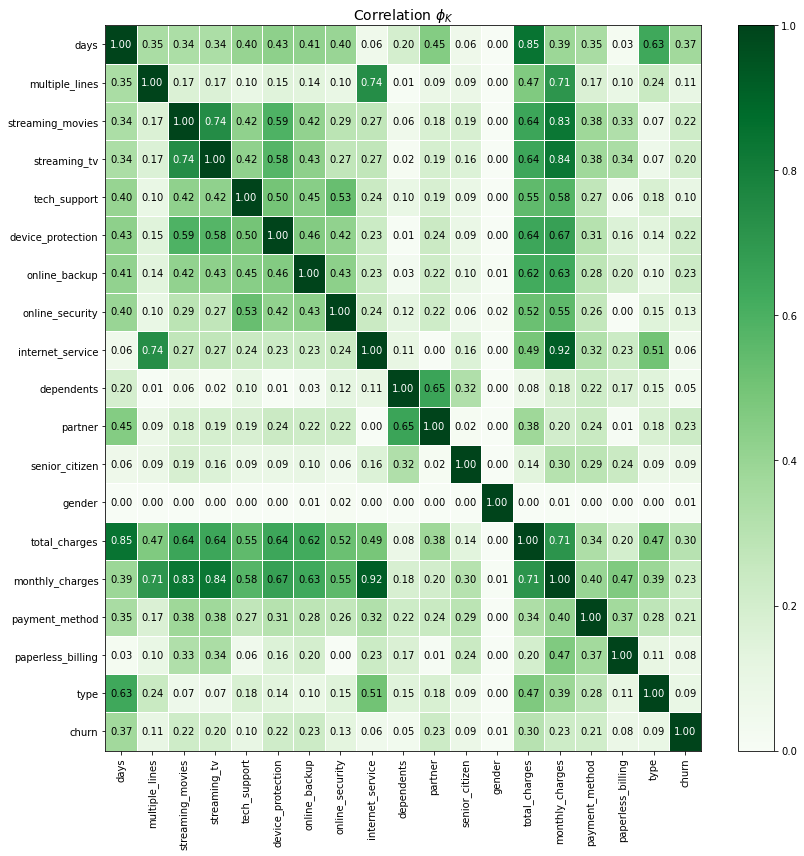

In [35]:
# построение матрицы корреляции с помощью библиотеки phik
interval_cols = data.select_dtypes('number').columns.tolist()
phik_overview = data.phik_matrix(interval_cols=interval_cols)
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"Correlation $\phi_K$", 
                        fontsize_factor=1, 
                        figsize=(12, 12))
plt.tight_layout()

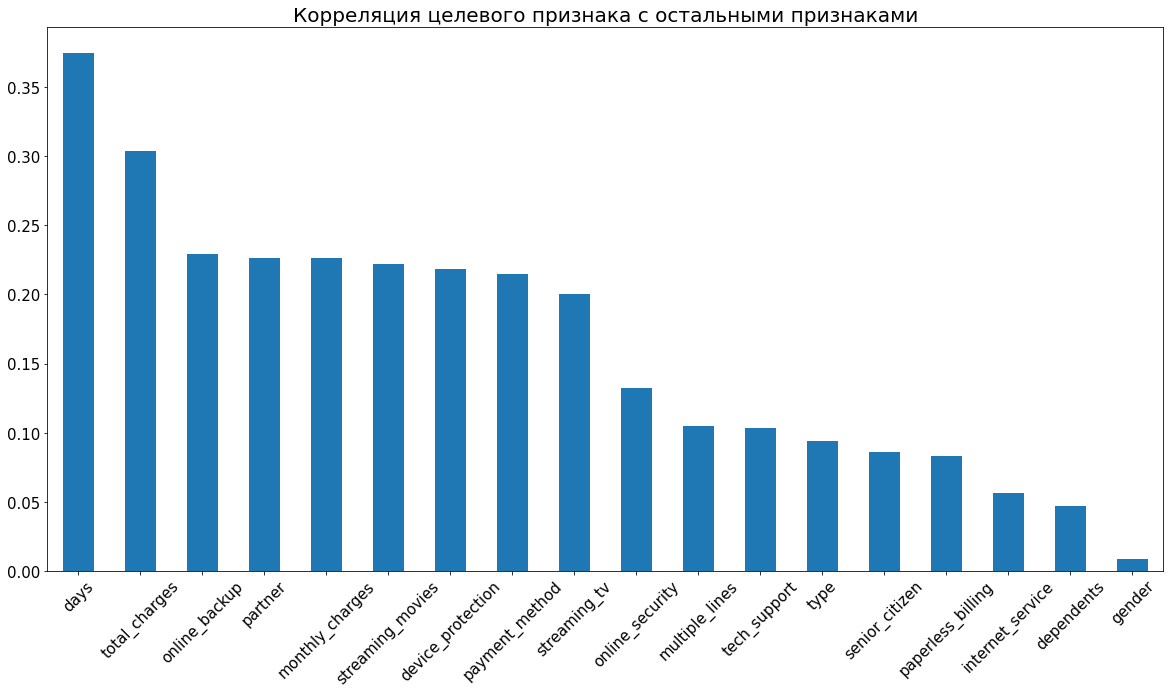

In [41]:
phik_overview['churn'].sort_values(ascending=False)[1:].plot(kind='bar', figsize=(20, 10)).tick_params(labelsize=15)
plt.title('Корреляция целевого признака с остальными признаками', fontsize=20)
plt.xticks(rotation=45);

По построенным графикам можно сделать следующие выводы:
* у целевого признака `'churn'` нет сильной корреляции ни с одним из признаков;
* наивысшая корреляция таргета с признаком `'days'`, однако, сама по себе она не очень высока;
* больше всего между собой коррелируют месячные траты, суммарные траты и наличие подключенных услуг: это логично, чем больше подключенных услуг, тем больше денег платит клиент.

### Подготовка выборок

#### Разделение данных на выборки

Разделим данные на признаки для обучения и целевой признак:

In [42]:
target = data['churn']
features = data.drop(['churn'], axis=1)

С помощью метода `train_test_split()` разделим данные на тренировочную и тестовую выборку в соотношении 3:1. Валидационная выборка не понадобится, так как при обучении будем использовать кросс-валидацию. При разделении укажем параметр `stratify=target`, так как в целевом признаке имеется сильный дисбаланс классов.

In [43]:
train_features, test_features, train_target, test_target = \
        train_test_split(features, target, test_size=0.25, random_state=RS, stratify=target)

Зафиксируем названия категориальных и числовых признаков в переменных `num` и `cat`.

In [44]:
num = ['monthly_charges', 'total_charges', 'days']
cat = list(features.drop(num, axis=1).columns)

#### Кодирование категориальных признаков

Для кодирования категориальных признаков воспользуемся кодировщиком `OneHotEncoder()`. Создадим новые переменные под названиями `train_features_ohe` и `test_features_ohe`. Предыдущие переменные оставим без изменения, они нам понадобятся для обучения модели градиентного бустинга `LGBMClassifier()`. В этой модели есть встроенный кодировщик, поэтому дополнительная кодировка нежелательна.

In [45]:
# кодирование категориальных признаков через OHE
encoder = OneHotEncoder(sparse=False, drop='first', handle_unknown='ignore')
encoder.fit(train_features[cat])

train_features_ohe = ohe(train_features)
test_features_ohe = ohe(test_features)

display(train_features.sample(3, random_state=RS))
display(train_features_ohe.sample(3, random_state=RS))

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,days
4914,Two year,No,Credit card (automatic),92.30,7044.34,Male,False,Yes,No,DSL,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2191
2182,One year,No,Mailed check,18.80,357.20,Male,False,No,No,Not used,No,No,No,No,No,No,No,580
651,Month-to-month,Yes,Electronic check,20.25,60.75,Male,False,No,No,Not used,No,No,No,No,No,No,No,92


,type_One year,type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,gender_Male,senior_citizen_True,partner_Yes,dependents_Yes,...,online_backup_Yes,device_protection_Yes,tech_support_Yes,streaming_tv_Yes,streaming_movies_Yes,multiple_lines_Not used,multiple_lines_Yes,monthly_charges,total_charges,days
4914,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,92.30,7044.34,2191
2182,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.80,357.20,580
651,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.25,60.75,92


#### Масштабирование числовых признаков

Для масштабирования числовых признаков воспользуемся инструментом `MinMaxScaler()`. Он приведёт все признаки к единому числовому диапазону: от 0 до 1.

In [46]:
# стандартизация числовых признаков через MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train_features[num])

train_features[num] = scaler.transform(train_features[num])
test_features[num] = scaler.transform(test_features[num])
train_features_ohe[num] = scaler.transform(train_features_ohe[num])
test_features_ohe[num] = scaler.transform(test_features_ohe[num])

display(train_features_ohe[num].sample(3, random_state=RS))

,monthly_charges,total_charges,days
4914,0.737157,0.763424,0.946845
2182,0.003990,0.036741,0.250648
651,0.018454,0.004526,0.039758


### Обучение моделей

#### `LGBMClassifier()`

Данные готовы к обучению. Для начала, воспользуемся заранее написанной функцией `to_cat_type()`, с её помощью преобразуем категориальные признаки из типа `object` в тип `category`. Именно в таком формате необходимо передавать их в модель градиентного бустинга `LGBMClassifier()`.

In [47]:
train_features = to_cat_type(train_features)
test_features = to_cat_type(test_features)

In [48]:
%%time
# LGBMClassifier
model_lgb = LGBMClassifier(random_state=RS)

params = {'n_estimators': np.arange(10, 101, 10), 
          'max_depth': np.arange(2, 53, 5),
          'learning_rate': [0.1, 0.01, 0.001]}
search_lgb = GridSearchCV(model_lgb, params, n_jobs=-1, cv=5, scoring='roc_auc')
search_lgb.fit(train_features, train_target);
best_lgb = search_lgb.best_estimator_
search_lgb.best_params_

CPU times: total: 14.1 s
Wall time: 43.2 s


{'learning_rate': 0.1, 'max_depth': 17, 'n_estimators': 100}

Сохраним лучшие параметры модели, а также лучшую метрику на кросс-валидации.

In [49]:
best_lgb_params = search_lgb.best_params_
best_lgb_score = search_lgb.best_score_

In [50]:
search_lgb.best_score_

0.8582054917825557

Модель достигла целевой метрики. Проверим ещё две модели.

#### `RandomForestClassifier()`

Обучим модель случайного леса. В этот раз воспользуемся уже закодированными данными.

In [51]:
%%time
# RandomForestClassifier
model_forest = RandomForestClassifier(random_state=RS)
params = {'max_depth': np.arange(2, 53, 5),
          'n_estimators': np.arange(10, 151, 10)}
search_forest = GridSearchCV(model_forest, params, n_jobs=-1, cv=5, scoring='roc_auc')
search_forest.fit(train_features_ohe, train_target)
best_forest = search_forest.best_estimator_
search_forest.best_params_

CPU times: total: 6.2 s
Wall time: 1min 3s


{'max_depth': 7, 'n_estimators': 120}

In [52]:
best_forest_params = search_forest.best_params_
best_forest_score = search_forest.best_score_

In [53]:
search_forest.best_score_

0.8192305899226693

Модель леса выдаёт недостаточно высокую метрику. Пока для проверки на тестовых данных подходит только модель градиентного бустинга.

#### `LogisticRegression()`

Обучим модель логистической регрессии. Для обучения также воспользуемся закодированными данными.

In [54]:
%%time
# LogisticRegression
model_lr = LogisticRegression()
params = {'C': np.arange(0.1, 20, 0.1)}
search_lr = GridSearchCV(model_lr, params, n_jobs=-1, cv=5, scoring='roc_auc')
search_lr.fit(train_features_ohe, train_target)
best_lr = search_lr.best_estimator_
search_lr.best_params_

CPU times: total: 4.8 s
Wall time: 11.8 s


{'C': 13.0}

In [55]:
best_lr_params = search_lr.best_params_
best_lr_score = search_lr.best_score_

In [56]:
search_lr.best_score_

0.7671782136973408

Модель логистической регрессии также не достигла целевой метрики. Перейдём к проверке на тестовых данных.

### Проверка лучшей модели 

Лучшей моделью на кроссвалидации оказалась модель `LGBMClassifier()` с гиперпараметрами `{'learning_rate': 0.1, 'max_depth': 17, 'n_estimators': 100}`. Проверим её работу на тестовых данных. Метрику ROC-AUC посчитаем с помощью `predict_proba()`.

In [57]:
test_roc_auc_score = roc_auc_score(test_target, best_lgb.predict_proba(test_features)[:, 1])
test_roc_auc_score

0.8784754680044049

Модель достигла целевой метрики на тестовых данных. Задачу можно считать выполненной. Дополнительно проверим значение метрики accuracy.

In [58]:
test_accuracy_score = accuracy_score(test_target, best_lgb.predict(test_features))
test_accuracy_score

0.879045996592845

Значения метрик AUC-ROC и accuracy на тестовых данных получились практически идентичными. Модель хорошо справляется с поставленной задачей и предсказывает уход клиента из компании.

### Сводная таблица по моделям

Для наглядности построим таблицу с параметрами моделей, а также полученными метриками.

In [59]:
results = pd.DataFrame([[best_lgb_score, best_forest_score, best_lr_score],
                        [best_lgb_params, best_forest_params, best_lr_params],
                        [test_roc_auc_score, '-', '-'],
                        [test_accuracy_score, '-', '-']],
                       columns=['LGBMRegressor', 'LinearRegression', 'DescisionTreeRegressor'],
                       index=['roc_auc_cv', 'model_params', 'roc_auc_test', 'accuracy_test'])
results.T

,roc_auc_cv,model_params,roc_auc_test,accuracy_test
LGBMRegressor,0.858205,"{'learning_rate': 0.1, 'max_depth': 17, 'n_est...",0.878475,0.879046
LinearRegression,0.819231,"{'max_depth': 7, 'n_estimators': 120}",-,-
DescisionTreeRegressor,0.767178,{'C': 13.0},-,-


### Feature importance

Дополнительно проверим важность признаков для лучшей модели. Для этого построим столбчатую диаграмму со всеми признаками.

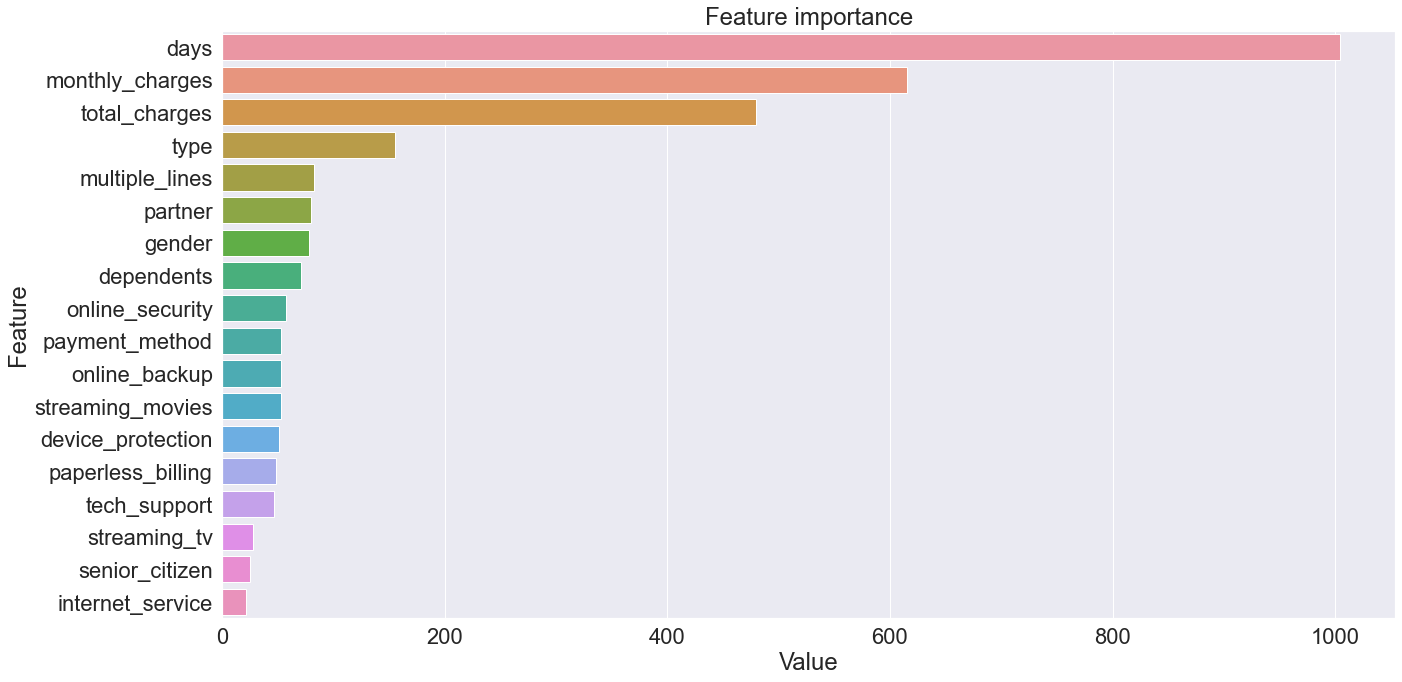

In [60]:
feature_imp = pd.DataFrame({'Value':best_lgb.feature_importances_,'Feature':train_features.columns})
plt.figure(figsize=(20, 10))
sns.set(font_scale = 2)
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Feature importance')
plt.tight_layout()
plt.show()

Ключевыми признаками для модели являются синтетический признак `days`, а также признаки определяющие траты клиента: `'monthly_charges'` и `'total_charges'`. В дальнейшем, для улучшения качества работы модели можно попробовать оставить только наиболее значимые признаки, и проверить метрики.

## Вывод

Работа над проектом была разделена на три части:
1. **Составление плана**, первичный анализ данных, выделение целевого признака.
2. **Написание кода**: предобработка данных, заполнение некорректных значений, проверка на коллинеарность, создание и обучение моделей, проверка моделей на тестовых данных. 
3. **Формирование отчёта**: создание последовательной структуры проекта, добавление разделов, добавление комментариев к каждому пункту работы, анализ обученных моделей, написание вывода.

Все пункты первоначального плана были выполнены. Был проведён анализ данных, данные были корректно соединены в единый датафрейм. В ходе предобработки, были заполнены некорректные значения, а также изменены неверные типы данных. Перед обучением моделей, был проведён анализ корреляции признаков с помощью `Phik`, кодирование категориальных признаков, а также масштабирование числовых признаков. У моделей осуществлялся перебор различных гиперпараметров, а метрика высчитывалась по кросс-валидации с помощью `GridSearchCV()`. После обучения моделей была составлена сводная таблица, в которой были указаны полученные метрики, а также гиперпараметры. Лучшая модель была проверена на тестовых данных, также, для неё был проведён анализ важности признаков.

Для обучения моделей использовались все признаки из первоначальных данных, кроме малоинформативного `'customerID'`, а также двух признаков с датами: `'BeginDate'` и `'EndDate'`. Однако, все эти признаки были использованы в работе: 
* по признаку `'customerID'` было осуществлено соединение данных из разных таблиц;
* признак `'EndDate'` был преобразован в целевой - `'churn'`;
* также, из признаков `'EndDate'` и `'BeginDate'` был создан синтетический признак `'days'`, указывающий на количество дней, в которые человек являлся клиентом компании.

По итогу выполнения проекта были обучены три модели классификации: `LGBMClassifier()`, `RandomForestRegressor()` и `Logistic Regressor()`. Целевой метрики достигла только модель градиентного бустинга, а самым важным признаком для этой модели, как раз оказался синтетический признак `'days'`. Значение ROC-AUC для лучшей модели `LGBMClassifier()` на **тренировочных** данных с кросс-валидацией составило **0.858**. На **тестовых** данных метрика стала ещё выше и составила **0.878**. На **тестовых** данных дополнительно измерялась метрика accuracy, её значение составило **0.879** Лучшая модель имеет следующие гиперпараметры: `{'learning_rate': 0.1, 'max_depth': 17, 'n_estimators': 100}`.


В ходе выполнения проекта возникли некоторые трудности по достижению целевой метрики. В первоначальной версии, вместо признака `'days'` был создан признак `'months'`, который указывал на количество месяцев. С признаком `'months'` ни одной модели не удавалось достичь целевой метрики.